### This file loads a saved model and evaluate it

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout

#helper modules
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib

### Load data

In [2]:
test_dir=pathlib.Path(".keras/datasets/isic_2019/test")
images_count=len(list(test_dir.glob("*/*.jpg")))

In [3]:
images_count

6117

In [4]:
CLASS_NAMES=['Benign','Malignant','Unknown']
BATCH_SIZE = 128
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANNELS=3
IMG_SHAPE=(IMG_HEIGHT, IMG_WIDTH,CHANNELS)

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [6]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == CLASS_NAMES

In [7]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

In [8]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [9]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(len(image_batch)):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[np.where(label_batch[n])[0][0]])
        plt.axis('off')

### Load the model

In [10]:
model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
#model.summary()

### Load test images

In [11]:
test_ds=tf.data.Dataset.list_files(str(test_dir/'*/*'))

In [12]:
# for f in test_ds.take(2):
#     print(f)

In [13]:
test_labeled_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [14]:
test_ds = test_labeled_ds.cache("vgg19_test_ds_cache.tmp")

In [15]:
test_ds=test_labeled_ds.batch(BATCH_SIZE)

In [18]:
#for test_batch, test_labels in test_ds:
    #print(test_batch.shape)

In [19]:
#show_batch(test_batch.numpy().take(25), test_batch.numpy().take(25))

### Make predictions

In [16]:
test_labels = np.zeros((images_count,3), dtype = "bool")
predictions = np.zeros((images_count,2), dtype = "float")

In [17]:
row_start = 0
row_end = 0
for test_batch, labels in test_ds:
    row_end =row_end + test_batch.shape[0] #set end index
    test_labels[row_start:row_end,] = labels #set test labels for us
    predictions[row_start:row_end,] = model.predict(test_batch) #set predictions for use
    row_start = row_end #reset start index

In [18]:
test_labels[:5]

array([[False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True]])

In [19]:
y_true = np.argmax(np.where(test_labels,1,0),axis=1)

In [20]:
y_true[:5]

array([2, 2, 2, 2, 2])

In [21]:
predictions[:5]

array([[3.51597555e-05, 9.99964833e-01],
       [9.99998808e-01, 1.20360971e-06],
       [9.99995828e-01, 4.17737510e-06],
       [8.53142701e-05, 9.99914646e-01],
       [5.71358614e-05, 9.99942899e-01]])

In [22]:
y_pred = np.argmax(predictions,axis=1)

In [27]:
y_pred[:5]

array([1, 0, 1, 0, 1])

### Functions needed

In [23]:
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from itertools import cycle

In [24]:
def my_evaluation(y_true,y_pred):
    acc=np.sum(np.equal(y_true,y_pred))/len(y_pred) #accuracy
    return(acc)

In [25]:
def plot_acc(acc):
    batch_range = range(len(acc))
    plt.figure(figsize=(5,5))
    plt.ylabel('Accuracy')
    plt.xlabel('Batch')
    plt.plot(batch_range, acc,'r--*')
    plt.title('Accuracy for {} test batches'.format(len(acc)))

In [26]:
def plot_cm(y_true, y_pred,label,title):
    cm = confusion_matrix(y_true, y_pred,labels=label)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(title)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

### Accuracy

In [27]:
# Get index of images for each class
b_idx = np.where(y_true == 0)[0]
m_idx = np.where(y_true == 1)[0]
u_idx = np.where(y_true == 2)[0]

Overall Accuracy

In [28]:
#Benign and malignant idx
bm_idx=np.hstack((b_idx,m_idx))

In [29]:
acc=my_evaluation(y_true[bm_idx],y_pred[bm_idx])
acc

0.8608247422680413

Class accuracy

In [30]:
# Class accuracy
b_acc = my_evaluation(y_true[b_idx],y_pred[b_idx])
m_acc = my_evaluation(y_true[m_idx],y_pred[m_idx])
print("Accuracy for Benign class {:.2f}".format(b_acc))
print("Accuracy for Malignant class {:.2f}".format(m_acc))

Accuracy for Benign class 0.89
Accuracy for Malignant class 0.82


In [35]:
#Taking Malignant = positive class.
y = y_true[bm_idx]
y.shape

(2134,)

In [36]:
pred_prob = predictions[bm_idx]
pred_prob.shape

(2134, 2)

In [37]:
p = y_true[m_idx]
n = y_true[b_idx]
tp = p[y_pred[m_idx]==1].shape[0]
fp = n[y_pred[b_idx]==1].shape[0]

**Precision**

In [38]:
precision = tp/(tp+fp)
precision

0.8273809523809523

**Recall**

In [39]:
recall = tp/p.shape[0]
recall

0.820543093270366

### Visualize accuracy for test batches

Confusion matrix for Benign and Malignant

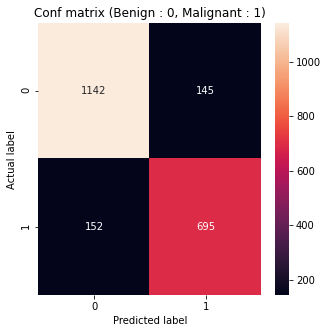

In [40]:
plot_cm(y_true[bm_idx],y_pred[bm_idx],[0,1],'Conf matrix (Benign : 0, Malignant : 1)')
plt.show()

**ROC and precision-recall Curve for Benign and malignant**

In [43]:
fpr, tpr, threshold = roc_curve(y, pred_prob[:,1],pos_label=1)

In [44]:
roc_auc = auc(fpr, tpr)
roc_auc

0.9137455749025997

In [45]:
# pre = []
# re = []
# max_prob =predictions[:,1] 
# for t in thres:
#     t_pred = np.where(max_prob < t,0,1)
#     t_p = p[t_pred[m_idx]==1].shape[0]
#     f_p = n[t_pred[b_idx]==1].shape[0]
#     if((t_p+f_p)>0):  
#         pre.append(t_p/(t_p+f_p))
#     if(len(p)>0):  
#         re.append(t_p/p.shape[0])

In [46]:
re,pre,thres = precision_recall_curve(y,pred_prob[:,1],pos_label=1)

In [47]:
pre[-5:]

array([0.39197166, 0.38252656, 0.36835891, 0.33057851, 0.        ])

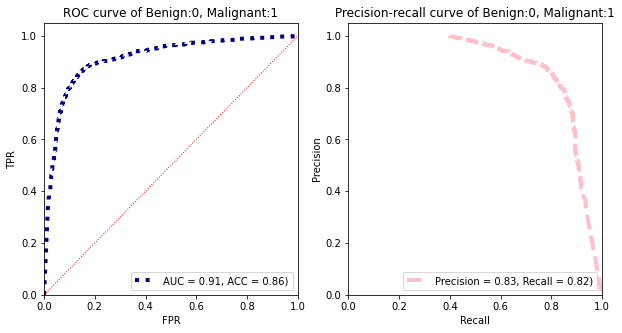

In [48]:
plt.figure(figsize=(10,5))
ax = plt.subplot(1,2,1)
plt.plot(fpr, tpr,
         label='AUC = {0:0.2f}, ACC = {1:0.2f})'
               ''.format(roc_auc,acc),
         color='navy', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], 'r:', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("ROC curve of Benign:0, Malignant:1")
plt.legend(loc="lower right")

ax = plt.subplot(1,2,2)
plt.plot(re, pre,
         label='Precision = {0:0.2f}, Recall = {1:0.2f})'
               ''.format(precision,recall),
         color='pink', linestyle='--', linewidth=4)
#plt.plot([1, 0], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Precision-recall curve of Benign:0, Malignant:1")
plt.legend(loc="lower right")

plt.show()

### Uncertainty estimation

**Histogram of softmax output for both classes**

In [49]:
max_prob = np.amax(predictions, axis=1)

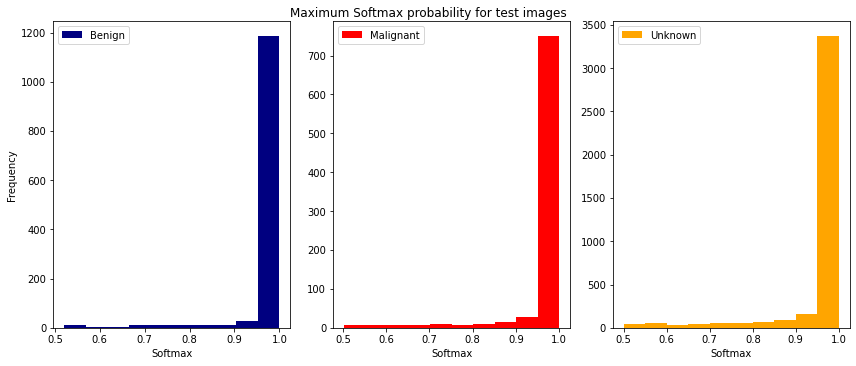

In [67]:
fig, (ax,ax1,ax2) =plt.subplots(1,3)
fig.set_size_inches(12,5)
h1 = ax.hist(max_prob[b_idx],density=False, label="Benign",color='navy')
ax.set_xlabel('Softmax')
ax.set_ylabel('Frequency')
#ax.axes.get_yaxis().set_visible(False)
ax.legend()
h2 = ax1.hist(max_prob[m_idx],density=False, label="Malignant", color='red')
ax1.set_xlabel('Softmax')
ax1.legend()
h3 = ax2.hist(max_prob[u_idx],density=False, label="Unknown",color='orange')
ax2.set_xlabel('Softmax')
ax2.legend()

plt.suptitle('Maximum Softmax probability for test images',va ='baseline')
plt.tight_layout()
plt.show()

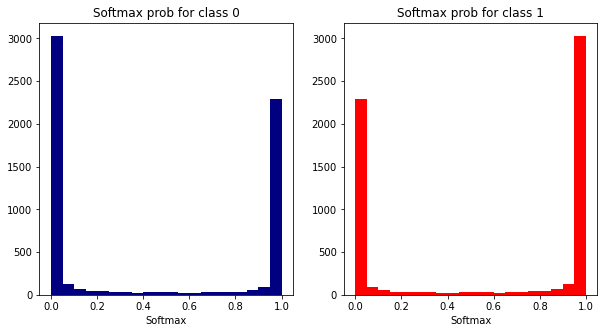

In [55]:
plt.figure(figsize=(10,5))
ax = plt.subplot(1,2,1)

plt.hist(predictions[:,0],color = 'navy',density=False,bins=20)
plt.xlabel('Softmax')
plt.title('Softmax prob for class 0')

ax = plt.subplot(1,2,2)
plt.hist(predictions[:,1], density = False, color = 'red',bins=20)
plt.xlabel('Softmax')
plt.title('Softmax prob for class 1')

plt.show()

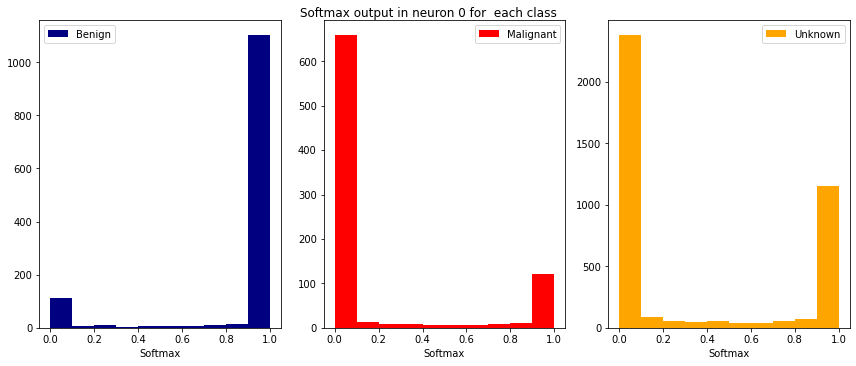

In [52]:
fig, (ax,ax1,ax2) =plt.subplots(1,3)
fig.set_size_inches(12,5)
h1 = ax.hist(predictions[b_idx,0],density=False, label="Benign",color='navy')
ax.set_xlabel('Softmax')
#ax.axes.get_yaxis().set_visible(False)
ax.legend()
h2 = ax1.hist(predictions[m_idx,0],density=False, label="Malignant", color='red')
ax1.set_xlabel('Softmax')
ax1.legend()
h3 = ax2.hist(predictions[u_idx,0],density=False, label="Unknown",color='orange')
ax2.set_xlabel('Softmax')
ax2.legend()

plt.suptitle('Softmax output in neuron 0 for  each class',va ='baseline')
plt.tight_layout()
plt.show()

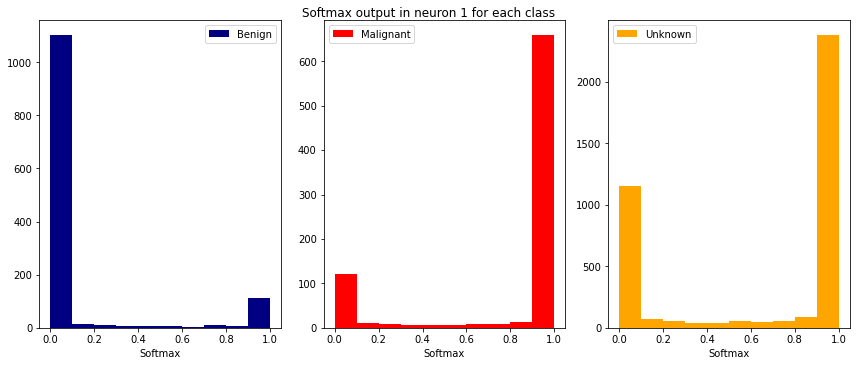

In [53]:
fig, (ax,ax1,ax2) =plt.subplots(1,3)
fig.set_size_inches(12,5)
h1 = ax.hist(predictions[b_idx,1],density=False, label="Benign",color='navy')
ax.set_xlabel('Softmax')
#ax.axes.get_yaxis().set_visible(False)
ax.legend()
h2 = ax1.hist(predictions[m_idx,1],density=False, label="Malignant", color='red')
ax1.set_xlabel('Softmax')
ax1.legend()
h3 = ax2.hist(predictions[u_idx,1],density=False, label="Unknown",color='orange')
ax2.set_xlabel('Softmax')
ax2.legend()

plt.suptitle('Softmax output in neuron 1 for each class',va ='baseline')
plt.tight_layout()
plt.show()

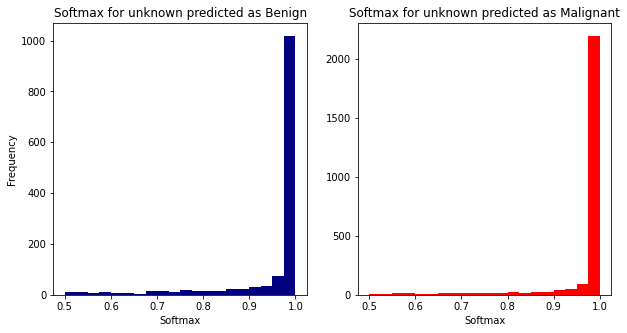

In [68]:
y_pred_un=y_pred[u_idx]
max_prob_un=max_prob[u_idx]

plt.figure(figsize=(10,5))
ax = plt.subplot(1,2,1)

plt.hist(max_prob_un[y_pred_un==0],color = 'navy',density=False,bins=20)
plt.xlabel('Softmax')
plt.ylabel('Frequency')
plt.title('Softmax for unknown predicted as Benign')

ax = plt.subplot(1,2,2)
plt.hist(max_prob_un[y_pred_un==1], density = False, color = 'red',bins=20)
plt.xlabel('Softmax')
plt.title('Softmax for unknown predicted as Malignant')

plt.show()

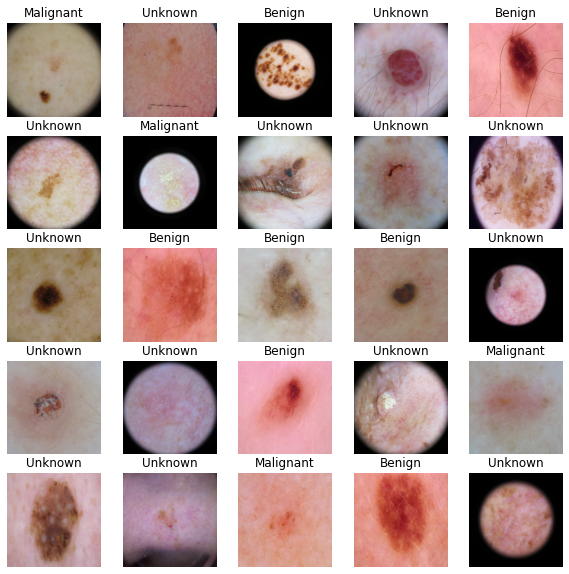

In [72]:
show_batch(test_batch[-25:], labels[-25:])

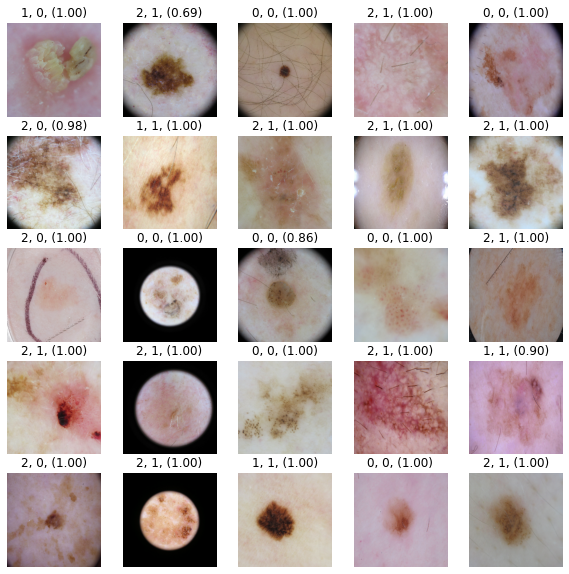

In [84]:
plt.figure(figsize=(10,10))
for n in range(len(test_batch[-25:])):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(test_batch[n])
    plt.title('{}, {}, ({:0.2f})'.format(y_true[-25:][n],y_pred[-25:][n],max_prob[-25:][n]))
    plt.axis('off')